# A/B Test Analytics

This project focuses on the analysis of the data generated by an A/B Test ran on an e-commerce website. The goal of the analysis is to understand if having user reviews on the products improves the conversion rate.

## Analysis Steps

This notebook contains the analysis broken down in 5 steps:

1. Experiment configuration;

2. Hypothesis testing and success rates;

3. Distribution plots of the samples;

4. Statistical power calculation;

5. Influence of sample size in the A/B Test.

## Imports

In [1]:
# Imports
import datetime
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as scs

# Plot formatting
plt.style.use('fivethirtyeight')
plt.figure(1 , figsize = (15 , 6))
%matplotlib inline

# Data Loading

Variant A is the control group.

Variant B is the test group.

In [2]:
# Loading data from CSV
df_sales = pd.read_csv('data/dataset.csv')
df_sales

id variant  purchase        date
0      0x6f9421       A     False  12/26/2019
1      0x59d442       A     False   8/16/2019
2      0x6db8f8       A      True   3/18/2019
3      0x68245d       A     False   2/13/2019
4      0x28566e       A     False   9/28/2019
...         ...     ...       ...         ...
54995  0x451451       A     False   6/19/2019
54996  0x871d51       A     False   3/22/2019
54997  0x50d163       A     False   2/10/2019
54998  0x3544c4       B     False    1/9/2020
54999  0x983331       A     False    9/5/2019

[55000 rows x 4 columns]

## Exploratory Analysis

In [3]:
# Data types
df_sales.dtypes

id          object
variant     object
purchase      bool
date        object
dtype: object

In [4]:
# Need to convert date from object to datetime
df_sales['date'] = pd.to_datetime(df_sales['date'], errors='coerce')

In [5]:
# Max date
df_sales['date'].max()

Timestamp('2020-01-30 00:00:00')

In [6]:
# Min date
df_sales['date'].min()

Timestamp('2019-01-01 00:00:00')

In [7]:
# Check for null values
df_sales.isnull().sum()

id          0
variant     0
purchase    0
date        0
dtype: int64

In [8]:
# Check for duplicate IDs
df_sales.id.value_counts().count()

55000

In [9]:
# Check overall conversion rate
df_sales.purchase.value_counts()

False    46416
True      8584
Name: purchase, dtype: int64

In [10]:
# Check the number of samples of each variant
df_sales.variant.value_counts()

A    50000
B     5000
Name: variant, dtype: int64

**Calculating basic probabilities**

In [11]:
# Probability of a user visualizing variant A
df_sales[df_sales.variant == 'A'].shape[0] / df_sales.shape[0] * 100

90.9090909090909

In [12]:
# Probability of a user visualizing variant B
df_sales[df_sales.variant == 'B'].shape[0] / df_sales.shape[0] * 100

9.090909090909092

In [13]:
# Total number of purchases realized
df_sales.purchase.sum()

8584

In [14]:
# Number of purchases realized on variant A
df_sales[df_sales.variant == 'A'].purchase.sum()

7603

In [15]:
# Number of purchases realized on variant B
df_sales[df_sales.variant == 'B'].purchase.sum()

981

In [16]:
# Overall conversion rate
df_sales.purchase.mean()

0.15607272727272728

In [17]:
# Conversion rate for variant A
df_sales[df_sales.variant == 'A'].purchase.mean()

0.15206

In [18]:
# Conversion rate for variant B
df_sales[df_sales.variant == 'B'].purchase.mean()

0.1962

## Part 1: Experiment Configuration

Do pages with user reviews increase the conversion rate?

Variant A: Shows comments and reviews from other users.

Variant B: Does not show comments and reviews on the produt page.

Given that there is a date associated with the records, it's technically possible to execute a continous hypothesis test as new events are observed. Although the challenge is to know whether to consider the test complete immediately after a variant is deemed superior or to coninue to run it for a period of time. Here since the test has already been completed the dataset will the considered as a whole without regard for the dates of the records.

Here we assume that Variant A is supeior, unless the new variant proves to generate higher conversion rates with a Type I Error rate of 5%, thus we define the hypotheses as:

* H0: PB - PA = 0
* H1: PB - PA <> 0

H0 affirms that the probability difference among both gruops is equals to zero.

H1 affirms that the probability difference among both gruops is greater than zero.

### Data Pre-Processsing

In [19]:
# Find the start date for the A/B test
df_sales[df_sales.variant == 'B'].date.min()

Timestamp('2020-01-01 00:00:00')

In [20]:
# Find the end date for the A/B test
df_sales[df_sales.variant == 'B'].date.max()

Timestamp('2020-01-30 00:00:00')

Looks like the test ran throughout january 2020, so we'll keep the data only from that period.

In [21]:
# The A/B Test was ran throughout january 2020
df_sales_2020 = df_sales[df_sales['date'].dt.year == 2020]
df_sales_2020 = df_sales_2020[df_sales['date'].dt.month == 1]
df_sales_2020.shape

C:\Users\Matheus\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


(8821, 4)

### Establishing a Baseline

Establishing a baseline conversion rate before running the hypothesis test. This is done in order to know the baseline conversion rate and the desired increase in conversion rate prior to running the test.

In [22]:
df_ab_data = df_sales_2020[['variant', 'purchase']]
df_ab_data.shape

(8821, 2)

In [23]:
# Ranaming the columns
df_ab_data.columns = ['group', 'conversion']
df_ab_data.head()

group  conversion
5      A       False
7      B       False
9      A       False
10     A       False
11     A       False

In [24]:
# Pivot table to summarize the data
df_ab_summary = df_ab_data.pivot_table(values='conversion', index='group', aggfunc=np.sum).astype('int')
df_ab_summary

conversion
group            
A             587
B             981

In [25]:
# Summary with total
df_ab_summary['total'] = df_ab_data.pivot_table(values='conversion', index='group', aggfunc=lambda x: len(x))

In [26]:
# Summary with rate
df_ab_summary['rate'] = df_ab_data.pivot_table(values='conversion', index='group', aggfunc=np.mean)

In [27]:
# Visualize
df_ab_summary

conversion  total      rate
group                             
A             587   3821  0.153625
B             981   5000  0.196200

In [28]:
# Values for Variant A
conversion_A = df_ab_summary['conversion'][0]
total_A = df_ab_summary['total'][0]
rate_A = df_ab_summary['rate'][0]
print('Variant A')
print('Conversion:', conversion_A)
print('Total:', total_A)
print('Rate:', rate_A)

Variant A
Conversion: 587
Total: 3821
Rate: 0.15362470557445695


In [29]:
# Values for Variant B
conversion_B = df_ab_summary['conversion'][1]
total_B = df_ab_summary['total'][1]
rate_B = df_ab_summary['rate'][1]
print('Variant B')
print('Conversion:', conversion_B)
print('Total:', total_B)
print('Rate:', rate_B)

Variant B
Conversion: 981
Total: 5000
Rate: 0.1962


In the context of a binomial distribution the baseline conversion rate is equal to $p$, where $p$ is the probability of success.

In [30]:
# Baseline conversion rate
baseline_conversion = rate_A
baseline_conversion

0.15362470557445695

In [31]:
# Minimum detectable effect
minimum_effect = rate_B - rate_A
minimum_effect

0.04257529442554306

## Part 2: Hypothesis Tests

Running the hypothesis test and registering the success rate for each group.

Statistical power (or sensibility) is equals to 1 - $\beta$.

For most analyses a statistical power of 80% is used. This is the probability of rejecting the null hypothesis when it is in fact false.

Parameters being used to run the test:

1- Alpha (Significance Level) $\alpha$: usually 5%; probability of rejecting the null hypothesis when it's true.

2- Beta $\beta$: Probability of accepting the null hypothesis when in reality it's false.

In [32]:
# Test parameters
alpha = 0.05
beta = 0.2

# Sample size
n = df_sales_2020.shape[0]

We can assume the distribution of the control group in binomial since the data are a series of Bernoulli experiments in which each experiment has only two possible results.

For the test I'll be using the binom() function in SciPy: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.binom.html

In [33]:
# Binomial Test
binom_test = scs.binom(n, p=baseline_conversion)

# Binomial Test with minimum detectable effect
binom_test_mde = scs.binom(n, p=baseline_conversion+minimum_effect)

In [34]:
help(binom_test)

Help on rv_frozen in module scipy.stats._distn_infrastructure object:

class rv_frozen(builtins.object)
 |  rv_frozen(dist, *args, **kwds)
 |  
 |  # Frozen RV class
 |  
 |  Methods defined here:
 |  
 |  __init__(self, dist, *args, **kwds)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  cdf(self, x)
 |  
 |  entropy(self)
 |  
 |  expect(self, func=None, lb=None, ub=None, conditional=False, **kwds)
 |  
 |  interval(self, alpha)
 |  
 |  isf(self, q)
 |  
 |  logcdf(self, x)
 |  
 |  logpdf(self, x)
 |  
 |  logpmf(self, k)
 |  
 |  logsf(self, x)
 |  
 |  mean(self)
 |  
 |  median(self)
 |  
 |  moment(self, n)
 |  
 |  pdf(self, x)
 |  
 |  pmf(self, k)
 |  
 |  ppf(self, q)
 |  
 |  rvs(self, size=None, random_state=None)
 |  
 |  sf(self, x)
 |  
 |  stats(self, moments='mv')
 |  
 |  std(self)
 |  
 |  support(self)
 |  
 |  var(self)
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here

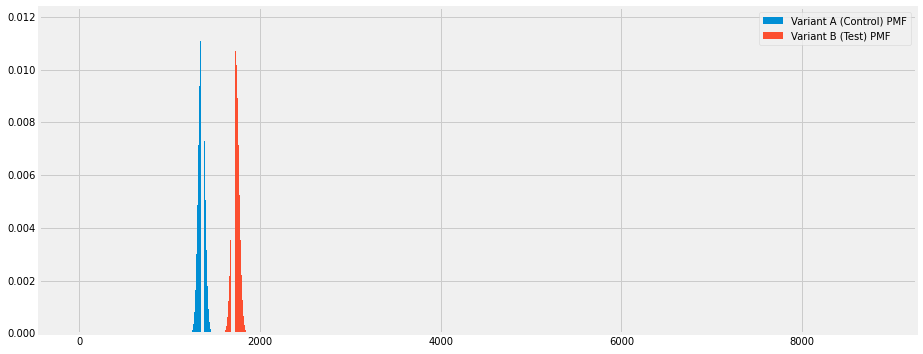

In [35]:
# Visualizing the probability mass functiin (pmf)
fig, ax = plt.subplots(figsize=(14,6))

# Defining values for the x-axis
x = np.linspace(0,int(n), int(n)+1)

# Plotting the results with a probability mass function
ax.bar(x, binom_test.pmf(x), label='Variant A (Control) PMF')
ax.bar(x, binom_test_mde.pmf(x), label='Variant B (Test) PMF')
ax.legend()
plt.show()

## Part 3: Distribution Plots

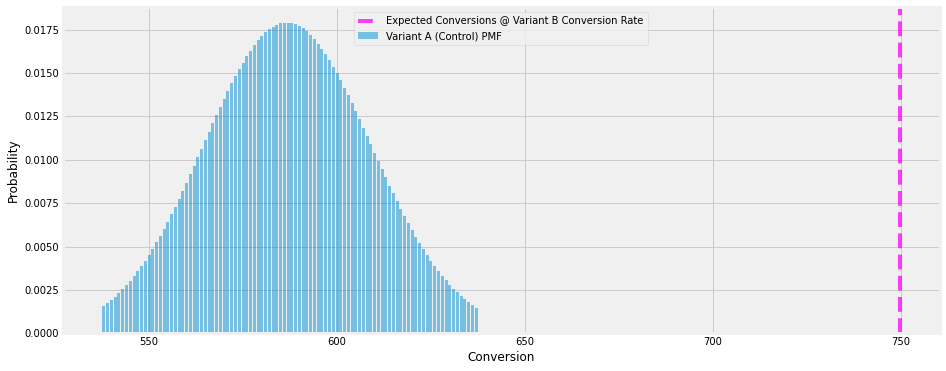

In [36]:
# Distribution plot for group A (control)
fig, ax = plt.subplots(figsize=(14,6))

# Test A
x = np.linspace(conversion_A-49, conversion_A+50, 100)
y = scs.binom(total_A, rate_A).pmf(x)

# Plots
ax.bar(x, y, alpha=0.5, label='Variant A (Control) PMF')
ax.axvline(x=rate_B*total_A, c='magenta', alpha=0.75, linestyle='--', label='Expected Conversions @ Variant B Conversion Rate')
ax.legend()

# Labels
plt.xlabel('Conversion')
plt.ylabel('Probability')
plt.show()

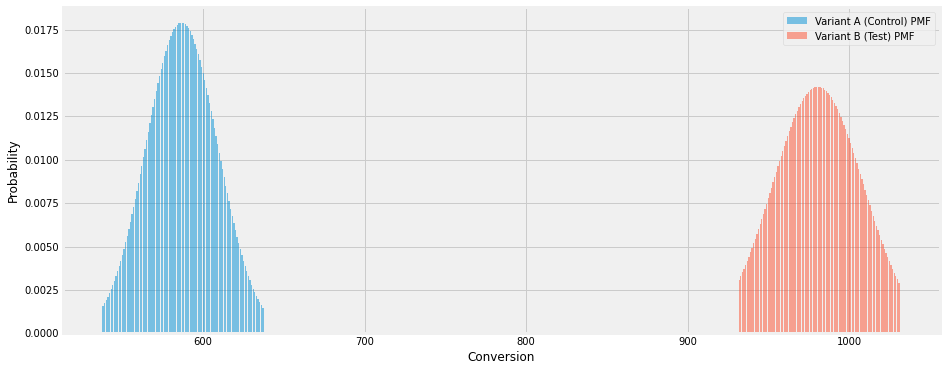

In [37]:
# Distribution plots for both groups
fig, ax = plt.subplots(figsize=(14,6))

# Variant A
xA = np.linspace(conversion_A-49, conversion_A+50, 100)
yA = scs.binom(total_A, rate_A).pmf(xA)
ax.bar(xA, yA, alpha=0.5, label='Variant A (Control) PMF')

# Variant B
xB = np.linspace(conversion_B-49, conversion_B+50, 100)
yB = scs.binom(total_B, rate_B).pmf(xB)
ax.bar(xB, yB, alpha=0.5, label='Variant B (Test) PMF')

# Labels
plt.xlabel('Conversion')
plt.ylabel('Probability')
ax.legend(loc='best')
plt.show()

It's evident the test group converted more users than the control group. Yet, it's equally evident that the probability associated with the results from the test group is lower than that of the control group.

Therefore, to properly compare the variants, we need to focus on the conversion rate, so that we are comparing equivalent terms. For that the data needs to be standardized and then we can compare the probabiblity of success, p, for each each group.

**Note on the Bernoulli Distribution and the Central Limit Theorem**

The Bernoulli distribution for the control group is given as 

``X ~ Bernoulli(p)``

where p is the probability of conversion for the control group. According to the Bernoulli Distribution properties, the mean and variance are as follows:

``E(X) = p``

``Var(X) = p(1-p)``

According to the Central Limit Theorem, if one calculates many sample means one can approximate the true mean for the population, $\mu$, from which the data for the control group were obtained. The distribution of sample means, p, will be normally distributed around the true mean with an standard deviation equals to the standard error of the mean.

The equation for this standard deviation is given as:
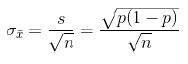

Therefore we can represent both groups with a gaussian distribution with the following properties:
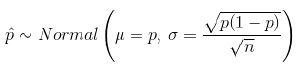

The same can be done for the test group (Variant B). Thus we'll have two normal distributions for p_A and p_B. The conversion from Bernoulli to Gaussian simplifies the rest of the analysis.

In [38]:
# Probabilities (= conversion rates)
p_A = rate_A
p_B = rate_B

# Number of conversions
N_A = total_A
N_B = total_B

# Standard error for the mean in both groups
SE_A = np.sqrt(p_A * (1 - p_A)) / np.sqrt(N_A)
SE_B = np.sqrt(p_B * (1 - p_B)) / np.sqrt(N_B)

# Print
print('Variant A Standard Error:', SE_A)
print('Variant B Standard Error:', SE_B)

Variant A Standard Error: 0.005833423432971666
Variant B Standard Error: 0.0056161474339621814


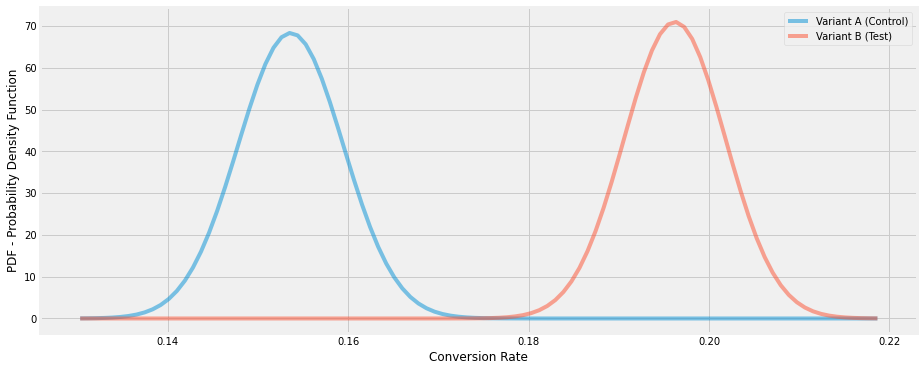

In [39]:
# Plotting the normal distribution for the null and alternative hypotheses
fig, ax = plt.subplots(figsize=(14,6))

# Data for the random variable
x = np.linspace(p_A-4*SE_A, p_B+4*SE_B, 100)

# Distribution of A
yA = scs.norm(p_A, SE_A).pdf(x)
ax.plot(x, yA, alpha=0.5, linestyle='-', label='Variant A (Control)')

# Distribution of B
yB = scs.norm(p_B, SE_B).pdf(x)
ax.plot(x, yB, alpha=0.5, linestyle='-', label='Variant B (Test)')

# Labels
ax.legend()
plt.xlabel('Conversion Rate')
plt.ylabel('PDF - Probability Density Function')
plt.show()

The continuous lines represent the normally distributed conversion rates for each group. The distance between the blue line and the red line is equals to the mean difference between the control and test groups.

**Variance of the Sum**

The null hypothesis states that the probability difference between both groups is zero. Therefore the mean for this normal distribution will be zero. The second property needed for the normal distribution is the standard deviation or variance...

A basic property of the variance is that the variance of the sum of two independent random variables is the sum of their variances:

``Var(X + Y) = Var(X) + Var(Y)``

``Var(X - Y) = Var(X) + Var(Y)``

This means that the null hypothesis and the alternative hypothesis will have the same variance, which is the sum of the variances for the control and test groups:
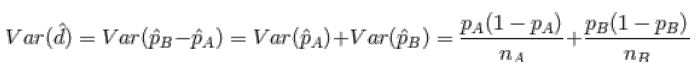
The standard deviation can be calculated as:
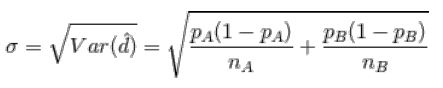
And if we place this equation in terms of the standard deviation for the Bernoulli distribution, we have:
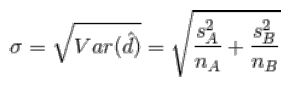
and we obtain the Satterthwaite approximation for the pooled standard error. If we calculate the combined probability and use it to calculate the standard deviation for both groups, we obtain:
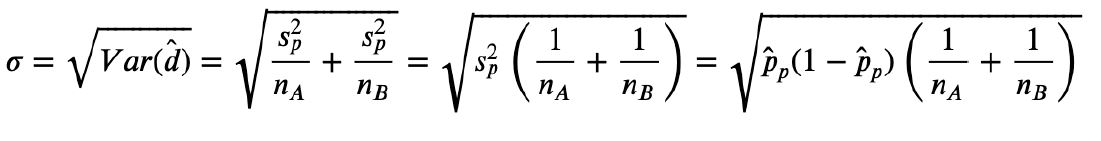
where:
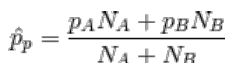
Both equations for the combined standard error will give very similar results.

**Verifying the Null Hypothesis and the Alternative Hypothesis**

The null hypothesis states that the change made in the page design made for the test group would not cause a change in conversion rate.

The alternative hypothesis is the opposing stance, affirming the change made in the page design made for the test group would cause a change in conversion rate.

The null hypothesis will be a normal distribution with mean zero and standard deviation equals to the pooled standard error.

The alternative hypothesis has the same standard deviation as the null hypothesis, but the mean will be the difference in conversion rate, d_hat. This makes sense because we can calculcate the difference in conversion rates directly from the data, while the normal distribution represents possible values that the experiment could have obtained.

Formula for the z-score:

$$ z = \frac{(\bar{x_1}-\bar{x_2})-D_0}{\sqrt{\sigma_1^{2}/n_1+\sigma_{2}^{2}/n_2}} $$

$$ z = \frac{(\hat{p_1}-\hat{p_2})-0}{\sqrt{\hat{p}\hat{q}(\frac{1}{n_1}+\frac{1}{n_2})}}$$

In [40]:
# Calculating the pooled probability
pooled_prob = (p_A*N_A + p_B*N_B) / (N_A+N_B)
pooled_prob

0.17775762385217095

In [41]:
# Calculating z
z = (p_B-p_A) / (pooled_prob*(1-pooled_prob) * (1/N_A + 1/N_B))**0.5
z

5.1827257006909795

In [42]:
# Veryfing if z is greater than the significance level
# The significance level for an alpha of 0.05 is 1.64
z > 1.64

True

### Plotting the Probability Distribution

Creating auxilary funtions to plot the probability distributions

In [43]:
# Function which returns the pooled probability for two samples
def pooled_prob_func(N_A, N_B, X_A, X_B):
    return (X_A + X_B) / (N_A + N_B)

In [44]:
# Function which results the pooled standard error for two samples
def pooled_standard_error_func(N_A, N_B, X_A, X_B):
    p_hat = pooled_prob_func(N_A, N_B, X_A, X_B)
    SE = np.sqrt(p_hat * (1 - p_hat) * (1 / N_A + 1 / N_B))
    return SE

In [45]:
# Return the z value for a given significance level
def z_val(sig_level = 0.05, two_tailed = True):
    
    # Generate the distribution for the z value
    z_dist = scs.norm()
    
    # Verify if both tails ought to be checked
    if two_tailed:
        sig_level = sig_level/2
        area = 1 - sig_level
    else:
        area = 1 - sig_level

    # Z value
    z = z_dist.ppf(area)

    return z

In [46]:
# Canculate the confidence interval
def confidence_interval(sample_mean = 0, sample_std = 1, sample_size = 1, sig_level = 0.05):
    
    # Calculate the z value
    z = z_val(sig_level)

    # Left and right limits
    left = sample_mean - z * sample_std / np.sqrt(sample_size)
    right = sample_mean + z * sample_std / np.sqrt(sample_size)

    return (left, right)

In [47]:
# Função que calcula o intervalo de confiança de duas caudas 
# Function to calculate the two-tailed confidence interval
def plot_CI(ax, 
            mu, 
            s, 
            sig_level = 0.05, 
            color = 'grey'):

    # Calculate the confidence interval
    left, right = confidence_interval(sample_mean = mu, sample_std = s, sig_level = sig_level)
    
    # Include the interval in the plot
    ax.axvline(left, c = color, linestyle = '--', alpha = 0.5)
    ax.axvline(right, c = color, linestyle = '--', alpha = 0.5)

In [48]:
# Function to plot a normal distribution
def plot_norm_dist(ax, 
                   mu, 
                   std, 
                   with_CI = False, 
                   sig_level = 0.05, 
                   label = None):

    # Generate values for a random variable x
    x = np.linspace(mu - 12 * std, mu + 12 * std, 1000)
    
    # Create a normal distribution
    y = scs.norm(mu, std).pdf(x)
    
    # Plot
    ax.plot(x, y, label = label)

    # If there's a confidence internval, include it on the plot
    if with_CI:
        plot_CI(ax, mu, std, sig_level = sig_level)

In [49]:
# Function to plot the distribution of the null hypothesis
# If there's no real change, the distribution of differences between the control and test groups will be normally distributed
def plot_H0(ax, stderr):
    plot_norm_dist(ax, 0, stderr, label = "H0 - Null Hypothesis")
    plot_CI(ax, mu = 0, s = stderr, sig_level = 0.05)

In [50]:
# Function to plot the distribution of the alternative hypothesis
# If there's a real change, the distribution of differences between the control and test groups will be normally disitributed 
# and centered around d_hat
def plot_H1(ax, stderr, d_hat):
    plot_norm_dist(ax, d_hat, stderr, label = "H1 - Alternative Hypothesis")

In [51]:
# Função que retorna um objeto de distribuição dependendo do tipo de grupo
# Function which returns a dsitribution object depending on the type of group
def ab_dist(stderr, d_hat = 0, group_type = 'control'):

    # Verify the group type
    if group_type == 'control':
        sample_mean = 0
    elif group_type == 'test':
        sample_mean = d_hat
        
    # Create a normal distribution which depends on the mean and standard deviation
    dist = scs.norm(sample_mean, stderr)
    return dist

In [52]:
# Function to fill between the upper and lower significance limit for the alternative hypothesis
def show_area(ax, d_hat, stderr, sig_level):

    # Confidence interval
    left, right = confidence_interval(sample_mean = 0, sample_std = stderr, sig_level = sig_level)
    
    # x values
    x = np.linspace(-12 * stderr, 12 * stderr, 1000)
    
    # H0
    null = ab_dist(stderr, 'control')
    
    # H1
    alternative = ab_dist(stderr, d_hat, 'test')

    # If the area type is equals to power
    # Fill between the upper significance limit and the distribuition for the alternative hypothesis
    ax.fill_between(x, 0, alternative.pdf(x), color = 'green', alpha = 0.25, where = (x > right))
    ax.text(-3 * stderr, null.pdf(0), 'power = {0:.3f}'.format(1 - alternative.cdf(right)), 
                fontsize = 12, ha = 'right', color = 'k')

In [53]:
# Function to return the p value
def p_val(N_A, N_B, p_A, p_B):
    return scs.binom(N_A, p_A).pmf(p_B * N_B)

In [54]:
# Function to plot the analysis of the A/B Test
def abplot_func(N_A, 
                N_B, 
                bcr, 
                d_hat, 
                sig_level = 0.05, 
                show_p_value = False,
                show_legend = True,
                two_tailed = True):

    # Define the plot area
    fig, ax = plt.subplots(figsize = (14, 8))

    # Define the parameters to find the pooled standard error
    X_A = bcr * N_A
    X_B = (bcr + d_hat) * N_B
    stderr = pooled_standard_error_func(N_A, N_B, X_A, X_B)

    # Plot the distribution for the null and alternative hypotheses
    plot_H0(ax, stderr)
    plot_H1(ax, stderr, d_hat)

    # Define the extension of the plot area
    ax.set_xlim(-8 * stderr, 8 * stderr)

    # Adjusting the plot and fill the inner area
    if two_tailed == True:
        show_area(ax, d_hat, stderr, sig_level)
    else:
        show_area(ax, d_hat, stderr, sig_level/2)

    # Showing p-values based on the distributions for the groups
    if show_p_value:
        null = ab_dist(stderr, 'control')
        p_value = p_val(N_A, N_B, bcr, bcr + d_hat)
        ax.text(3 * stderr, null.pdf(0), 'p-value = {0:.4f}'.format(p_value), fontsize = 14, ha = 'left')

    # Show legend
    if show_legend:
        plt.legend()

    plt.xlabel('d')
    plt.ylabel('PDF - Probability Density Functions')
    plt.show()

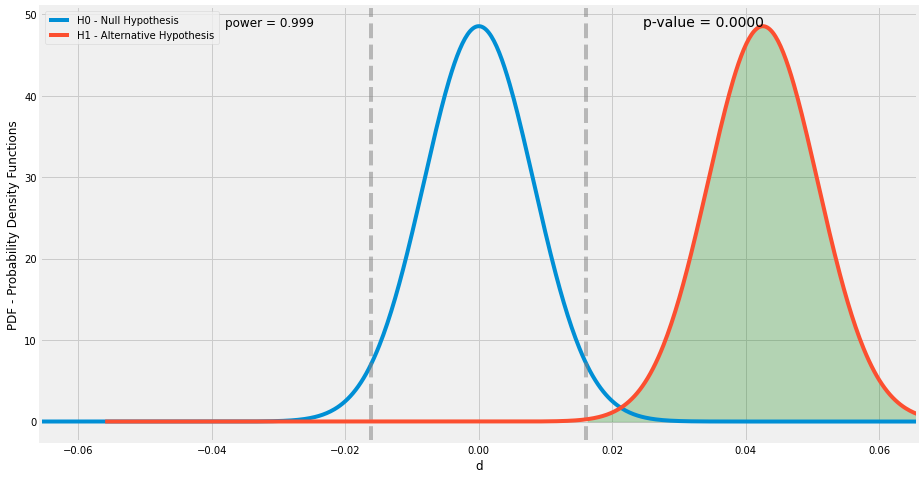

In [55]:
# Define the parameters and execute the function
n = N_A + N_B
baseline_conversion = p_A  
d_hat = p_B - p_A
abplot_func(N_A, N_B, baseline_conversion, d_hat, show_p_value = True)

Visually the plot for the normalized null and alternative hypotheses is very similar to the other plots above. Since both curves have an identical shape we can simply compare the distance between the means of the distributions. The curve for the alternative hypothesis suggests that the test group has a greater conversion rate when compared to the control group. This plot can also be used to directly determine the statistical power.

## Part 4: Calculating the Statistical Power

The statistical power calculations have been added to the plot above, and the value obtained is 0.998, which is over the desired 0.8 amount.

The shaded green area represents the statistical power and the calculated value can also be shown on the plot. The gray dashed lines on the plot above represent the confidence interval (95% for plot above) for the null hypothesis. The statistical power is calculated by finding the area under the alternative hypothesis curve aand out of the confidence intervall for the null hypothesis.

After executing the experiment we obtain a conversion rate for both groups. If we calculate the difference between the conversion rates we obtain a result that is the difference or effect from the change in wabpage design, not showing the user reviews and comments. The task is then to determine if the finding is resultand from the null or alternative hypothesis.

The area under the curve for the alternative hypothesis is equals to 1. If the alternative design (removal of reviews) is truly superior, then the power is the probability of accepting the alternative hypothesis and rejecting the null hypothesis, and it's equals to the shaded green area (true positive). The opposite area under the alternative curve is the probability of not rejecting the null hypothesis and instead rejecting the alternative hypothesis (false negative). This is the beta on an A/B test.

If the null hypothesis is true and there is no difference between the control and test groups, then the significance level is the probability of rejecting the null hypothesis and accepting the alternative hypothesis (false positive). A false positive is when we erroneously conclude that the new design is better when in reality it isn't. This value is low because we want to limit this probability.

The 95% confidence internval used translates into a significance level of 0.05, which is a common choice of value.

The experiments are usually configurated with a minimal desired potency over 80%. If our new deisng is truly superior, we want the experiment to show that there is at least an 80% probability that this is the case. We know that if the sample size for each group is increased, we'll reduce the combined variance for the hypotheses. This makes the distributions narrower and can increase the statistical power. Next I'll analyse how the sample size affects the findings.

## Part 5: Influence of Sample Size in the A/B Test

The statistical significance of the findings has already been established. Yet I'm also interested in determining the minimum sample size needed for the experiment. It's useful to know this since it's directly related to how quickly experiments can be completed and consequently how quickly one can generate insights.

In [56]:
# Function to include the z value on the plot
def zplot(area = 0.95, two_tailed = True, align_right = False):

    # Create the plot area
    fig = plt.figure(figsize = (12, 6))
    ax = fig.subplots()
    
    # Create a normal distribution
    norm = scs.norm()
    
    # Create the datapoints for the plot
    x = np.linspace(-5, 5, 1000)
    y = norm.pdf(x)

    ax.plot(x, y)

    # Code to fill the areas for two-tailed tests
    if two_tailed:
        left = norm.ppf(0.5 - area / 2)
        right = norm.ppf(0.5 + area / 2)
        ax.vlines(right, 0, norm.pdf(right), color = 'grey', linestyle = '--')
        ax.vlines(left, 0, norm.pdf(left), color = 'grey', linestyle = '--')

        ax.fill_between(x, 0, y, color = 'grey', alpha = 0.25, where = (x > left) & (x < right))
        
        plt.xlabel('z')
        plt.ylabel('PDF')
        plt.text(left, norm.pdf(left), "z = {0:.3f}".format(left), 
                 fontsize = 12, 
                 rotation = 90, 
                 va = "bottom", 
                 ha = "right")
        plt.text(right, norm.pdf(right), "z = {0:.3f}".format(right), 
                 fontsize = 12, 
                 rotation = 90, 
                 va = "bottom", 
                 ha = "left")
    
    # For single tailed tests
    else:
        # Right alignment
        if align_right:
            left = norm.ppf(1-area)
            ax.vlines(left, 0, norm.pdf(left), color = 'grey', linestyle = '--')
            ax.fill_between(x, 0, y, color = 'grey', alpha = 0.25, where = x > left)
            plt.text(left, norm.pdf(left), "z = {0:.3f}".format(left), 
                     fontsize = 12, 
                     rotation = 90, 
                     va = "bottom", 
                     ha = "right")
        
        # Left alignment
        else:
            right = norm.ppf(area)
            ax.vlines(right, 0, norm.pdf(right), color = 'grey', linestyle = '--')
            ax.fill_between(x, 0, y, color = 'grey', alpha = 0.25, where = x < right)
            plt.text(right, norm.pdf(right), "z = {0:.3f}".format(right), 
                     fontsize = 12, 
                     rotation = 90, 
                     va = "bottom", 
                     ha = "left")

    # Incluímos texto no plot
    plt.text(0, 0.1, "Shaded Area = {0:.3f}".format(area), fontsize = 12, ha = 'center')
    
    # Labels
    plt.xlabel('z')
    plt.ylabel('PDF')

    plt.show()

In [57]:
# Print z value
print(z)
print(z_val(sig_level = 0.05, two_tailed = False))
print(z > z_val(sig_level = 0.05, two_tailed = False))

5.1827257006909795
1.6448536269514722
True


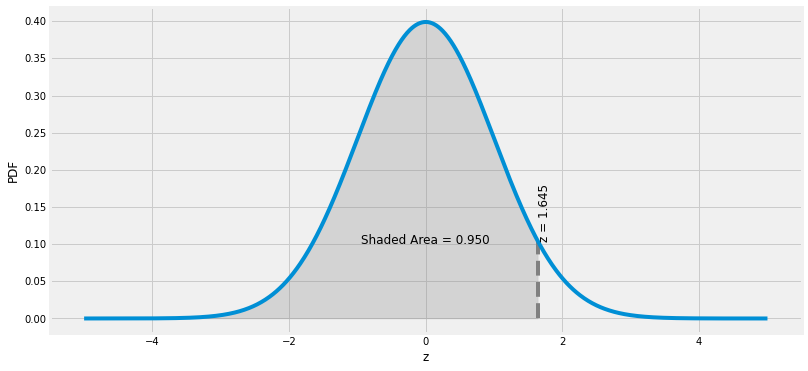

In [58]:
# Plot z
zplot(area = 0.95, two_tailed = False, align_right = False)

Equation to find the minimum sample size:

$$ n_A = k*n_B $$

$$ n_B = (\frac{p_A(1-p_A)}{k}+p_B(1-p_B)) (\frac{Z_{1-\alpha} + Z_{1-\beta}}{p_A-p_B})^{2}$$

$$ n = \frac{2(\bar{p})(1-\bar{p})(Z_{1-\beta}+Z_{1-\alpha})^2}{(p_B-p_A)^2}$$

In [59]:
# Calculate values for z, alpha and beta
sig_level = 0.05
beta = 0.2
k = N_A/N_B
standard_norm = scs.norm(0, 1)
Z_beta = standard_norm.ppf(1-beta)
Z_alpha = standard_norm.ppf(1-sig_level)
print(Z_beta)
print(Z_alpha)

0.8416212335729143
1.6448536269514722


Now finding the mimimum sample size.

In [60]:
# Function to find the minimum sample size
def calculate_min_sample_size(N_A, 
                                N_B, 
                                p_A, 
                                p_B, 
                                power = 0.8, 
                                sig_level = 0.05, 
                                two_sided = False):
   
    k = N_A/N_B
    
    # Normal distribution to determine z values
    standard_norm = scs.norm(0, 1)

    # Find the z value for the statistical power
    Z_beta = standard_norm.ppf(power)
    
    # Find z alpha
    if two_sided == True:
        Z_alpha = standard_norm.ppf(1-sig_level/2)
    else:
        Z_alpha = standard_norm.ppf(1-sig_level)

    # Pooled probability
    pooled_prob = (p_A + p_B) / 2

    # Minimum sample size
    min_N = (2 * pooled_prob * (1 - pooled_prob) * (Z_beta + Z_alpha)**2 / minimum_effect**2)    

    return min_N

In [61]:
# Calculate the minimum sample size with two_sided = True
min_N = calculate_min_sample_size(N_A, N_B, p_A, p_B, power = 0.8, sig_level = 0.05, two_sided = True)
min_N

1249.8068972849476

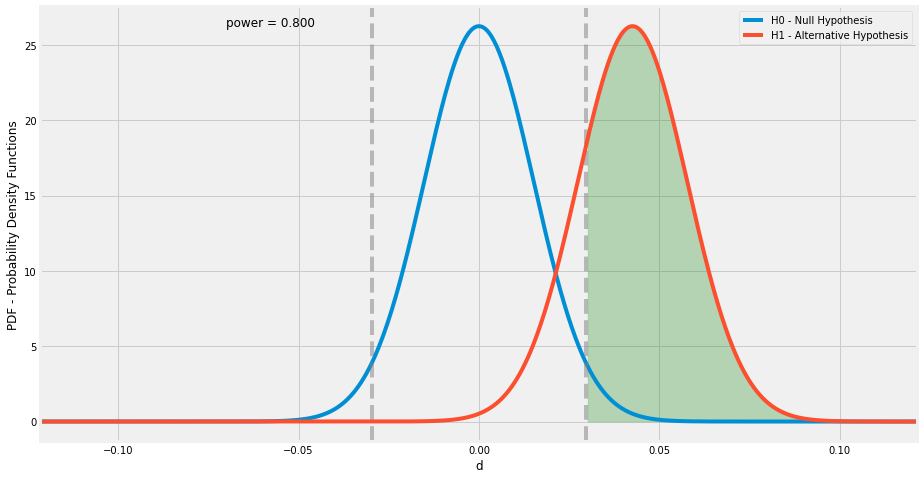

In [62]:
# Execute the function with two_sided = True
abplot_func(N_A = min_N, 
            N_B = min_N, 
            bcr = p_A, 
            d_hat = p_B - p_A, 
            sig_level = 0.05, 
            show_p_value = False, 
            show_legend = True)

**Calculating the minimum sample size considering the baseline**

This is done with the minimum sample size equation instead of using the statistical power method.
The idea here is checking if this simpler approach would also achieve an acceptable statistical power.

In [63]:
baseline_conversion + minimum_effect

0.1962

In [64]:
# Calcualte the pooled probability
pooled_probability = (baseline_conversion + baseline_conversion + minimum_effect) / 2
pooled_probability

0.1749123527872285

In [65]:
# Sum of z alpha and beta
Z_alpha + Z_beta

2.4864748605243863

In [66]:
# Minimum sample size for the baseline
min_N = (2 * pooled_probability * (1 - pooled_probability) * (Z_beta + Z_alpha)**2 / minimum_effect**2)
min_N

984.4720435225323

Statistical power for the baseline

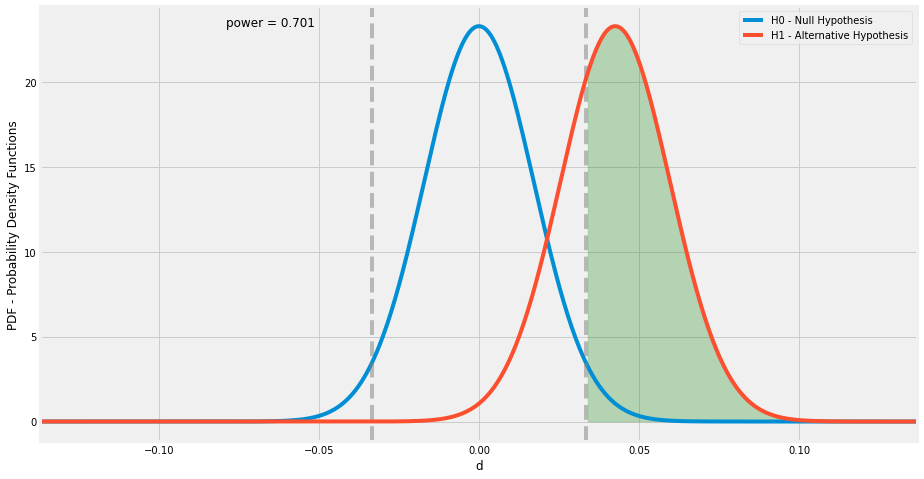

In [67]:
# Execute the function with min_N
abplot_func(N_A = min_N, 
            N_B = min_N, 
            bcr = p_A, 
            d_hat = p_B - p_A, 
            sig_level = 0.05, 
            show_p_value = False, 
            show_legend = True)

The calculated power for this sample size was of around 0.80. Therefore, in order to affirm that the change in page layout removing user reviews truly increased the conversion rate a minimum of 1249 samples are needed.

## Conclusion and Final Considerations

After going through all planned analysis steps, we can conclude from the gathered A/B Test samples that removing comments and reviews from the webpage (Variant B, the test) leads to an increased conversion rate, with an statistical power of 0.999.

We also observe that a safe conclusion could have been reached after only 1249 samples had been collected, which would have reduced the test time.

# End

https://matheus-schmitz.github.io/

https://www.linkedin.com/in/matheusschmitz/